# Homework Computer vision 

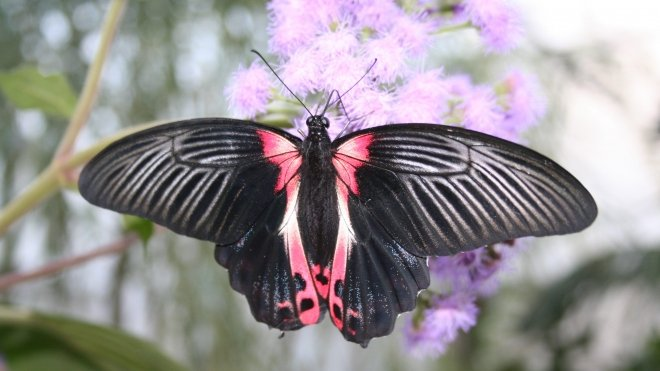

## Opdracht

In deze opgave is het de bedoeling dat je met behulp van een neuraal netwerk __afbeeldingen van vlinders classificeert__. Je doet dit aan de hand van een door ons aangeleverde dataset.
Deze notebook is reeds voorzien van enkele hoofdstukken. Het is dan ook de bedoeling dat je je zelf code en tekst schrijft onder het desbetreffende onderdeel.

Geef ook een __duidelijke argumentatie voor je gemaakte keuzes__. We streven naar een robuust model dat goed presteert, maar je argumentatie is minstens even belangrijk (zodat het duidelijk is dat je de materie onder de knie hebt).

Je rapportering gebeurt in de notebook zelf. *Let erop dat wanneer je tekst wil ingeven, je notebook cell hiervoor op Markdown ingesteld staat.* Je bent trouwens niet beperkt tot de technieken die we in de theorie/labo gezien hebben, maar zorg er steeds voor dat je je keuze kan becommentarieren en/of kan staven door het resultaat van enkele experimentjes.

__Tip:__ De standaard documentatie van de TensorFlow API kan een grote meerwaarde zijn. Wanneer je de cursor plaatst binnen de ronde haakjes van een Python functie en vervolgens SHIFT + TAB indrukt, verschijnt de documentatie van deze functie automatisch.

De **verbetersleutel** ziet er als volgt uit:


|  Onderdeel    | # punten | 
|-----------|:--------:|
|  Data inlezen en voorbereiden | /2 |
|  Model definitie| /6 | 
|  &emsp;- definitie lagen, neuronen en activatiefuncties |
|  &emsp;- keuze loss functie en  evaluatiemetric|
|  &emsp;- keuze optimizer (vergelijk min 2 optimizers) |
|  Regularisatie | /6 |  
|  &emsp; (test en bespreek hier min 3 technieken) | |  
|  Rapportering (gemaakte keuzes + evaluatie model)|     /6   |  
|  &emsp; (de rapportering hoeft geen aaneengesloten tekst te zijn en mag je gerust voorzien tussen je code-cellen) | |
|      Totaal: |     /20    | 

### Praktische afspraken:
Dit project wordt ingediend door deze notebook verder thuis af te werken en te uploaden op Toledo voor de start van je labo in **de week van maandag 10 janauri 2022.** Hiervoor maak je een .ZIP bestand van je notebook en eventueel extra data die je nodig hebt om jouw notebook uit te voeren. Op het einde van deze notebook wordt gevraagd __om je model op te slaan__, zodat we je model eenvoudig kunnen uitvoeren en uiteindelijk een scorebord kunnen maken van alle inzendingen. De vlinders dataset zelf hoef je niet mee te sturen. 

#### Alvast veel succes!

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np
import glob, os
import PIL
import pathlib
import datetime
import PIL.Image

%load_ext tensorboard

In [2]:
print(tf.__version__)

2.7.0


## Dataset

We werken op een dataset van vlinders. De dataset bestaat uit __464 examples__. Het is niet de bedoeling dat je de dataset zelf nog aanrijkt, maar je mag bijvoorbeeld wel gebruik maken van *Transfer Learning*.

In [3]:
data_filepath = 'dataset/'

## Data inlezen en voorbereiden

In [4]:
data_dir = pathlib.Path(data_filepath)

In [5]:
image_count = len([s for s in list(data_dir.glob('*/*.*')) if s.name != ".DS_Store"])
print("Aantal afbeeldingen:", image_count)

Aantal afbeeldingen: 464


In [6]:
BATCH_SIZE = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_filepath,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 464 files belonging to 5 classes.
Using 348 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_filepath,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 464 files belonging to 5 classes.
Using 116 files for validation.


Labels

In [8]:
class_names = {i : train_ds.class_names[i] for i in range(0, len(train_ds.class_names))}
class_names

{0: 'Bhutan Glory',
 1: 'Chimaera Birdwing',
 2: 'Kaiser-i-Hind',
 3: "Lange's Metalmark",
 4: 'Palos Verdes Blue'}

In [9]:
for train_images, train_labels in train_ds:
    print("train images shape:", train_images.shape)
    print("train labels shape:", train_labels.shape)
    break
    
for test_images, test_labels in val_ds:
    print("test images shape:", test_images.shape)
    print("test labels shape:", test_labels.shape)
    break

train images shape: (32, 128, 128, 3)
train labels shape: (32,)
test images shape: (32, 128, 128, 3)
test labels shape: (32,)


In [10]:
print("Dimensies trainingset: {}".format(train_ds))
print("Dimensies testset: {}".format(val_ds))

Dimensies trainingset: <BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>
Dimensies testset: <BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>


### Data visualisatie

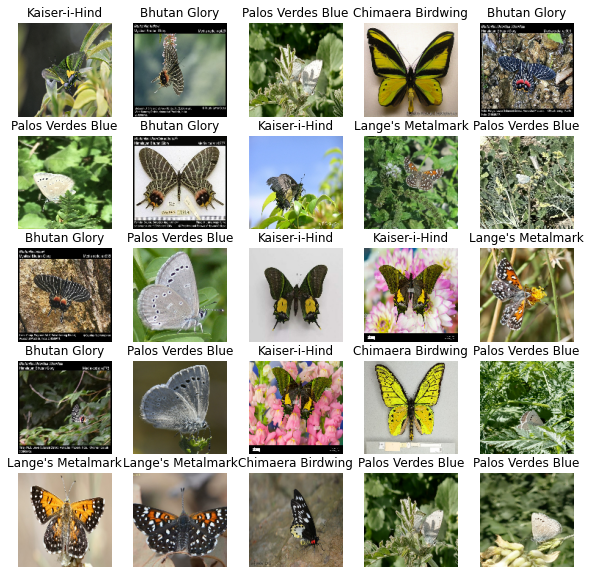

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

## Model definitie

In deze sectie stel je het neural netwerk samen en wordt het getraind op de trainingsdata. Gebruik <code>model</code> als variabelenaam voor je model.

In [12]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [13]:
# Compileer je model dmv de model.compile() functie

model.compile(
    optimizer='adam', #stochastic gradient descent methode
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', 'mse', 'sparse_categorical_accuracy']
)

In [14]:
NUM_EPOCHS = 7
BATCH_SIZE = 64

In [15]:
history = model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=val_ds, batch_size=BATCH_SIZE)

Epoch 1/7
11/11 [==============================] - 14s 1s/step - loss: 1.5871 - accuracy: 0.2414 - mse: 5.6311 - sparse_categorical_accuracy: 0.2414 - val_loss: 1.5204 - val_accuracy: 0.2414 - val_mse: 5.3972 - val_sparse_categorical_accuracy: 0.2414
Epoch 2/7
11/11 [==============================] - 12s 1s/step - loss: 1.4177 - accuracy: 0.4282 - mse: 5.6360 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.1471 - val_accuracy: 0.5431 - val_mse: 5.4204 - val_sparse_categorical_accuracy: 0.5431
Epoch 3/7
11/11 [==============================] - 12s 1s/step - loss: 1.0436 - accuracy: 0.6178 - mse: 5.6706 - sparse_categorical_accuracy: 0.6178 - val_loss: 0.7835 - val_accuracy: 0.7586 - val_mse: 5.4493 - val_sparse_categorical_accuracy: 0.7586
Epoch 4/7
11/11 [==============================] - 12s 1s/step - loss: 0.7843 - accuracy: 0.7270 - mse: 5.7003 - sparse_categorical_accuracy: 0.7270 - val_loss: 0.7058 - val_accuracy: 0.7586 - val_mse: 5.4736 - val_sparse_categorical_accuracy: 0.7

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        7

## Model evaluatie

Uitleg evaluatie

In [17]:
test_loss, test_accuracy, test_mse, test_sparse_cat_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print("test accuracy", test_accuracy)
print("test loss", test_loss)
print("test mean square error", test_mse)
print("test sparse_categoria accuracy", test_sparse_cat_accuracy)

1/1 - 0s - loss: 0.5771 - accuracy: 0.7812 - mse: 5.4525 - sparse_categorical_accuracy: 0.7812 - 414ms/epoch - 414ms/step
test accuracy 0.78125
test loss 0.577059268951416
test mean square error 5.452542304992676
test sparse_categoria accuracy 0.78125


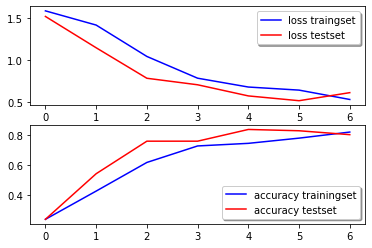

In [18]:
# Evalueer je mode dmv de model.evaluate() functie
_, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='loss traingset')
ax[0].plot(history.history['val_loss'], color='r', label='loss testset')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='accuracy trainingset')
ax[1].plot(history.history['val_accuracy'], color='r', label='accuracy testset')
legend = ax[1].legend(loc='best', shadow=True)

In [19]:
def test_butterly_prediction(model, butterfly_url):
    butterfly_path = tf.keras.utils.get_file(origin=butterfly_url)

    img = tf.keras.utils.load_img(butterfly_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    butterfly_predictions = model.predict(img_array)
    butterfly_score = tf.nn.softmax(butterfly_predictions[0])

    print("Probabiliteiten over alle 5 soorten", butterfly_predictions)
    print()
    print("Deze afbeelding is met {:.2f}% zekerheid een {} vlinder."
        .format(100 * np.max(butterfly_predictions[0]), class_names[np.argmax(butterfly_score)]))
    return (img)

Probabiliteiten over alle 5 soorten [[5.5487303e-04 1.0387404e-03 1.3456612e-03 7.7400762e-03 9.8932064e-01]]

Deze afbeelding is met 98.93% zekerheid een Palos Verdes Blue vlinder.
afbeelding:


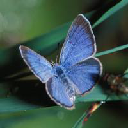

In [21]:
# Lange's Metalmark
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/e/ec/Apodemia_mormo_langei-02.JPG"

#Bhutan Glory
#butterfly_url = "https://pennybrownillustrations.files.wordpress.com/2016/10/bhutan-glory-resized.jpg"

#Chimaera Birdwing
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/a/ae/Ornithoptera_chimaera_m.jpg"

#Kaiser-i-Hind
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/BinghamTeinopalpus.jpg"

#Palos Verdes Blue
butterfly_url = "https://upload.wikimedia.org/wikipedia/en/5/56/PVBlue.jpg"

img = test_butterly_prediction(model, butterfly_url)
print("afbeelding:")
img

### Waarom wordt de Bhutan Glory fout geclassificeerd en de anderen niet?

De Bhutan Glory dataset bevatten een reeks aan foto's waarop de vlinder bruin alsook zwart vertoond wordt.
Hierdoor lijkt de Bhutan Glory sterk op de Lange's Metalmark vlinder.
Deze bias in de Bhutan Glory dataset zorgt ervoor dat deze vlinder overgefit wordt richting de Lange's Metalmark.

De 2 foto's hieronder tonen een foto van de Bhutan Glory en de Lange's Metalmark met de duidelijke gelijkenis (kleur en vorm).
Beide classes scoren minder goed (76.1% en 51.9%) dan de 3 ander vlinder categorieën die meer dan 80-90% scoren.

Scores volgens bovenstaande predict test:

- Lange's Metalmark: <b>76.07%</b>
- Bhutan Glory: <b>51.90%</b> (fout geclasificeerd als Lange's Metalmark vlinder)
- Chimaera Birdwing: <b>86.89%</b>
- Kaiser-i-Hind: <b>90.58%</b>
- Palos Verdes Blue: <b>91.56%</b>


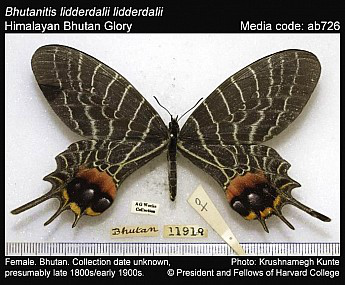

In [22]:
bhutan_glory = list(data_dir.glob('Bhutan Glory/*'))
PIL.Image.open(str(bhutan_glory[45]))

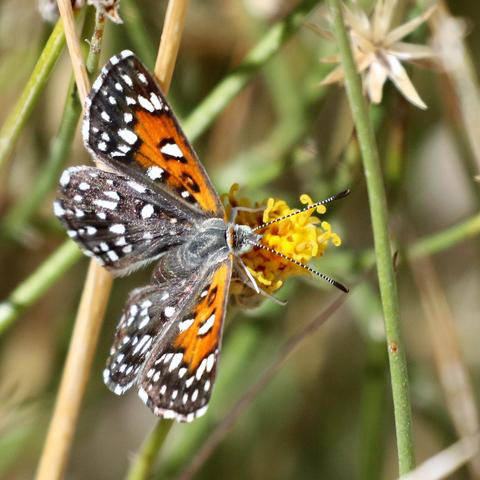

In [23]:
langes_metalmark = list(data_dir.glob("Lange's Metalmark/*"))
PIL.Image.open(str(langes_metalmark[12]))

## Data augmentatie

### Early Stopping

Using callbacks
Callbacks in Keras are objects that are called at different points during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They can be used to implement certain behaviors, such as:

Doing validation at different points during training (beyond the built-in per-epoch validation)
Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
Changing the learning rate of the model when training seems to be plateauing
Doing fine-tuning of the top layers when training seems to be plateauing
Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
Etc.
Callbacks can be passed as a list to your call to fit():

In [24]:
# Data augmetation
datagen = ImageDataGenerator(
    rotation_range=0.4,  
    zoom_range = 0.1, 
    horizontal_flip=True
)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
  ])

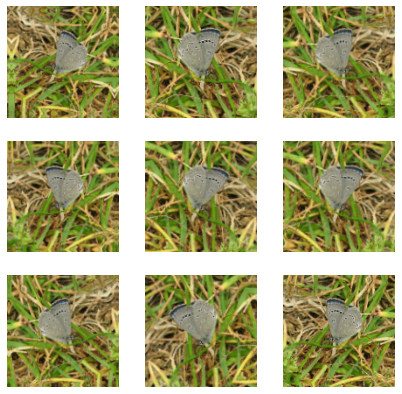

In [25]:
#Data augmentatie visueel weergegeven

plt.figure(figsize=(7,7))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [26]:
augmentation_model = Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [27]:
augmentation_model.compile(
    optimizer='adam', #stochastic gradient descent methode
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1)

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.



In [29]:
early_stopping_history = augmentation_model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE), 
                                 validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=[es])

Epoch 1/7
1/1 [==============================] - 4s 4s/step - loss: 1.6130 - accuracy: 0.2500 - val_loss: 1.6068 - val_accuracy: 0.3276
Epoch 2/7
1/1 [==============================] - 3s 3s/step - loss: 1.5521 - accuracy: 0.2188 - val_loss: 1.7321 - val_accuracy: 0.2328
Epoch 00002: early stopping


Probabiliteiten over alle 5 soorten [[5.5487303e-04 1.0387404e-03 1.3456612e-03 7.7400762e-03 9.8932064e-01]]

Deze afbeelding is met 98.93% zekerheid een Palos Verdes Blue vlinder.
afbeelding:


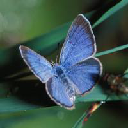

In [30]:
# Lange's Metalmark
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/e/ec/Apodemia_mormo_langei-02.JPG"

#Bhutan Glory
#butterfly_url = "https://pennybrownillustrations.files.wordpress.com/2016/10/bhutan-glory-resized.jpg"

#Chimaera Birdwing
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/a/ae/Ornithoptera_chimaera_m.jpg"

#Kaiser-i-Hind
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/BinghamTeinopalpus.jpg"

#Palos Verdes Blue
butterfly_url = "https://upload.wikimedia.org/wikipedia/en/5/56/PVBlue.jpg"

img = test_butterly_prediction(model, butterfly_url)
print("afbeelding:")
img

In [31]:
score = model.evaluate(val_ds, verbose=0)
print("Model zonder regularisatie")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

print()

score = augmentation_model.evaluate(val_ds, verbose=0)
print("Augmentated model met Early Stopping")
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


Model zonder regularisatie
Test loss: 0.6118890643119812 / Test accuracy: 0.8017241358757019

Augmentated model met Early Stopping
Test loss: 1.7320547103881836 / Test accuracy: 0.23275862634181976


In [32]:
predictions = model.predict(val_ds)
predicted_labels = predictions.argmax(axis=-1)
predicted_labels

array([3, 4, 0, 0, 0, 0, 4, 4, 4, 2, 2, 4, 1, 3, 2, 3, 1, 3, 4, 1, 4, 2,
       2, 3, 4, 0, 4, 0, 4, 3, 3, 0, 3, 4, 4, 0, 2, 1, 3, 3, 3, 0, 0, 0,
       4, 3, 2, 3, 4, 3, 4, 0, 4, 4, 1, 3, 3, 4, 3, 3, 4, 1, 0, 0, 0, 2,
       3, 0, 3, 4, 2, 4, 4, 2, 4, 3, 1, 0, 3, 3, 1, 3, 4, 4, 2, 3, 4, 4,
       4, 4, 0, 3, 0, 4, 3, 4, 0, 3, 4, 2, 3, 3, 4, 4, 2, 0, 4, 2, 2, 0,
       4, 4, 0, 0, 0, 3])

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

In [34]:
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=tensorboard_callback)

Epoch 1/7
11/11 [==============================] - 13s 1s/step - loss: 0.4374 - accuracy: 0.8420 - mse: 5.7332 - sparse_categorical_accuracy: 0.8420 - val_loss: 0.3576 - val_accuracy: 0.8793 - val_mse: 5.5074 - val_sparse_categorical_accuracy: 0.8793
Epoch 2/7
11/11 [==============================] - 13s 1s/step - loss: 0.4236 - accuracy: 0.8506 - mse: 5.7450 - sparse_categorical_accuracy: 0.8506 - val_loss: 0.4731 - val_accuracy: 0.8448 - val_mse: 5.4982 - val_sparse_categorical_accuracy: 0.8448
Epoch 3/7
11/11 [==============================] - 13s 1s/step - loss: 0.3842 - accuracy: 0.8592 - mse: 5.7422 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.4340 - val_accuracy: 0.8448 - val_mse: 5.5050 - val_sparse_categorical_accuracy: 0.8448
Epoch 4/7
11/11 [==============================] - 12s 1s/step - loss: 0.4042 - accuracy: 0.8448 - mse: 5.7429 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.4031 - val_accuracy: 0.8621 - val_mse: 5.5003 - val_sparse_categorical_accuracy: 0.8

In [35]:
history.history

{'loss': [0.4374368190765381,
  0.42357999086380005,
  0.3841615915298462,
  0.4041881263256073,
  0.3969973921775818,
  0.25775447487831116,
  0.1990089863538742],
 'accuracy': [0.8419540524482727,
  0.8505747318267822,
  0.8591954112052917,
  0.8448275923728943,
  0.8649425506591797,
  0.9051724076271057,
  0.931034505367279],
 'mse': [5.733244895935059,
  5.7449846267700195,
  5.74215841293335,
  5.742875576019287,
  5.7402825355529785,
  5.750233173370361,
  5.761106491088867],
 'sparse_categorical_accuracy': [0.8419540524482727,
  0.8505747318267822,
  0.8591954112052917,
  0.8448275923728943,
  0.8649425506591797,
  0.9051724076271057,
  0.931034505367279],
 'val_loss': [0.3575816750526428,
  0.47305887937545776,
  0.4339558780193329,
  0.4030517339706421,
  0.4301827847957611,
  0.41758736968040466,
  0.3334480822086334],
 'val_accuracy': [0.8793103694915771,
  0.8448275923728943,
  0.8448275923728943,
  0.8620689511299133,
  0.8448275923728943,
  0.8620689511299133,
  0.9051724

## Evalueren van het model na toepassen van regularisatie

In [36]:
def plot_history(val1, val2, plot_name):
    c1 = history.history[val1]
    c2 = history.history[val2]
    
    epochs = range(len(c1))
  
    plt.plot(epochs, c1, 'b', label=val1)
    plt.plot(epochs, c2, 'r', label=val2)
    plt.title(str(plot_name))
    plt.legend(['train', 'test'], loc='upper left')

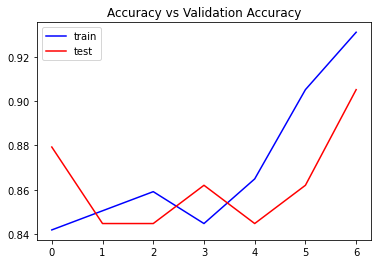

In [37]:
plot_history('accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')

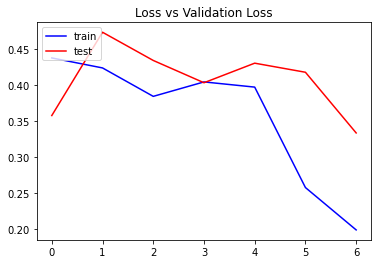

In [38]:
plot_history('loss', 'val_loss', 'Loss vs Validation Loss')

In [39]:
# Predict en plot 30 afbeeldingen

predicted_batch = model.predict(val_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)

predicted_label_batch = predicted_id.numpy()

In [40]:
preds = model.predict(val_ds)
pred_labels = tf.argmax(preds, axis = -1)

print("Predicted label:", pred_labels)
print("Prediction output:", preds)

Predicted label: tf.Tensor(
[3 2 3 0 3 4 3 2 3 3 4 3 4 0 4 4 4 1 2 3 0 3 2 1 2 2 3 4 0 0 4 0 2 0 4 0 2
 0 1 3 4 4 3 0 3 3 0 3 0 0 1 3 0 1 0 2 3 3 2 3 2 4 4 0 2 0 2 3 2 3 2 4 2 2
 4 2 3 2 2 2 0 1 2 4 2 0 1 1 3 3 2 3 1 4 0 0 3 4 3 0 2 4 4 0 1 0 4 2 3 1 3
 2 3 0 4 2], shape=(116,), dtype=int64)
Prediction output: [[5.62320456e-05 1.00601406e-03 1.65816542e-04 9.98397529e-01
  3.74378695e-04]
 [7.64756522e-04 1.19098499e-02 9.15958762e-01 1.37998853e-02
  5.75666837e-02]
 [4.88920175e-02 5.64038008e-03 1.76448226e-01 7.41780698e-01
  2.72386987e-02]
 [9.99450862e-01 3.43117676e-06 5.32261911e-04 4.48104913e-07
  1.30395538e-05]
 [3.23319039e-03 1.43104699e-03 2.76164059e-02 9.05193448e-01
  6.25259429e-02]
 [1.29365624e-04 8.09764897e-04 1.12131762e-03 5.16274362e-04
  9.97423291e-01]
 [1.73992455e-01 2.77264029e-01 1.98379140e-02 5.23579121e-01
  5.32648573e-03]
 [1.44145079e-03 2.56573915e-01 4.78488296e-01 6.12238534e-02
  2.02272490e-01]
 [3.45680416e-02 2.48102043e-02 5.40070198e-02 8

## Model opslaan

Maak gebruik van volgend commando om je model op te slaan. Voeg dit tenslotte toe aan jouw inzending zodat wij je model kunnen evalueren met een test dataset.

In [41]:
model.save('saved_models/model', include_optimizer=True, save_format='tf')

INFO:tensorflow:Assets written to: saved_models/model/assets


In [42]:
saved_model = load_model('saved_models/model', compile = True)

In [43]:
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        7

In [44]:
newScore = saved_model.evaluate(test_images, test_labels, verbose=0)
print(f'Test loss: {newScore[0]} / Test accuracy: {newScore[1]}')

Test loss: 0.40429094433784485 / Test accuracy: 0.875


Foto ophalen van internet

Probabiliteiten over alle 5 soorten [[0.00442786 0.09750585 0.04216864 0.85400045 0.00189719]]

Deze afbeelding is met 85.40% zekerheid een Lange's Metalmark vlinder.
afbeelding:


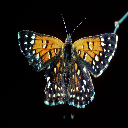

In [45]:
# Lange's Metalmark
butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/e/ec/Apodemia_mormo_langei-02.JPG"

#Bhutan Glory
#butterfly_url = "https://pennybrownillustrations.files.wordpress.com/2016/10/bhutan-glory-resized.jpg"

#Chimaera Birdwing
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/a/ae/Ornithoptera_chimaera_m.jpg"

#Kaiser-i-Hind
#butterfly_url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/BinghamTeinopalpus.jpg"

#Palos Verdes Blue
#butterfly_url = "https://upload.wikimedia.org/wikipedia/en/5/56/PVBlue.jpg"

img = test_butterly_prediction(saved_model, butterfly_url)
print("afbeelding:")
img

### Visuele weergave model

Visuele weergave van het opgeslagen en ingeladen model

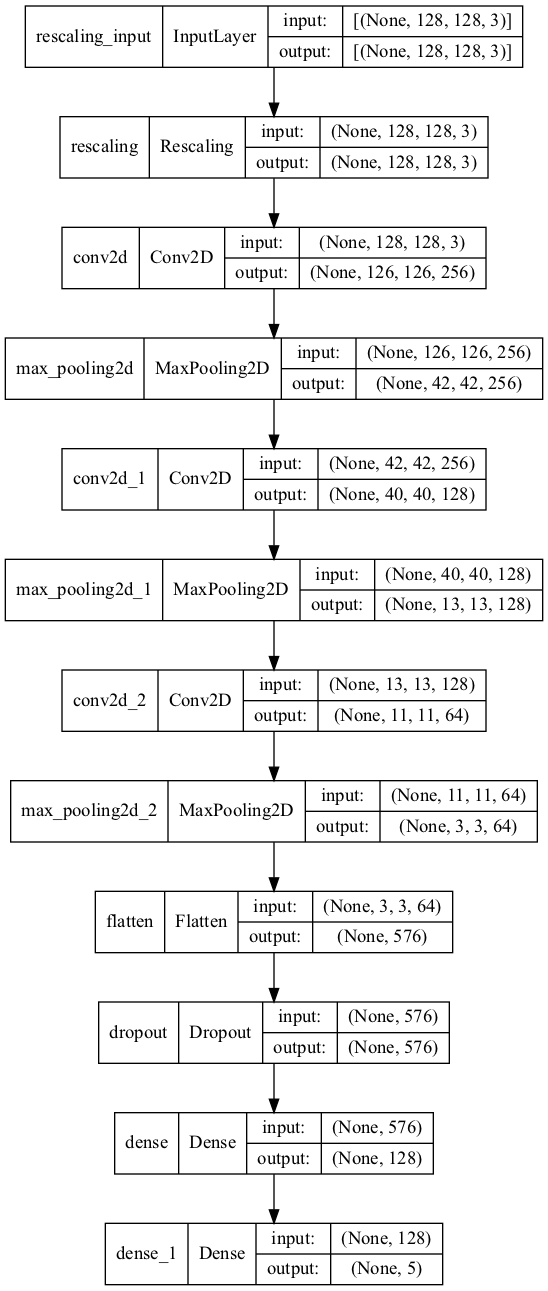

In [46]:
tf.keras.utils.plot_model(saved_model, "multi_input_and_output_model.png", show_shapes=True)